# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.


Несмотря на то, что основная причина использования Negative Sampling - улучшение скорости тренировки word2vec, в нашем игрушечном примере мы **не требуем** улучшения производительности. Мы используем negative sampling просто как дополнительное упражнение для знакомства с PyTorch.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import random

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [29]:
import os
import numpy as np
def get_OneHot_by_index(index, num_tokens):
    vector = [0]*num_tokens
    vector[index] = 1
    return torch.tensor(vector)

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences_by_token = {}
        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for i, word in enumerate(words):
                    if word in self.token_freq:
                        self.token_freq[word] +=1
                        self.sentences_by_token[word].append((len(self.sentences) - 1, i))
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
                        self.sentences_by_token[word] = [(len(self.sentences) - 1, i)] 
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
     
    def get_OneHot_by_token(self, token):
        return get_OneHot_by_index(self.index_by_token[token], self.num_tokens())
    
    def find_sentence_with_token(self, token, sentence_index, context_length = 5):
        for i, x in enumerate(self.sentences_by_token[token]):
            if sentence_index == x[0]:
                sentence = [word for word in self.sentences[sentence_index] \
                                if self.check_reject(word)]
                begin = max(x[1] - context_length//2, 0)
                end = min(x[1] + context_length//2, len(sentence))
                sequence = sentence[:begin] + sentence[end+1:]
                if sequence != []:
                    return random.choice(sequence)
        return None

    def get_random_out_context(self, token, num_negatives_samples, context_length = 5):
        result = []
        while len(result) < num_negatives_samples:
            sentence_index = np.random.randint(len(self.sentences))
            chosen_token = self.find_sentence_with_token(token, sentence_index, context_length)
            if chosen_token != None:
                result.append(chosen_token)
            else:
                while True:
                    chosen_token = random.choice(self.sentences[sentence_index])
                    if self.check_reject(chosen_token):
                        result.append(chosen_token)
                        break
        return result
    
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
print("Num sentences:", len(data.sentences))
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)
    out_context = data.get_random_out_context(center_word, 5, 5)
    print(out_context)

Num tokens: 19538
Num sentences: 11855
case ['nature', 'suffers', 'arrested']
['intentions', 'sad', 'everything', 'courageous', 'childlike']
bleed ['completely', 'dry']
['crashing', 'satire', 'full-length', 'undisputed', 'nuanced']
chãâ¢teau ['been', 'benefited']
['work', 'does', 'appear', 'expands', 'shots']
imax ['personal', 'manual']
['sudsy', 'convince', 'redemption', 'chloroform-soaked', 'proving']
rage ['...', 'blasts', 'later']
['proven', 'self-destructive', 'laws', 'borstal', 'contemptible']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [92]:
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        
        # TODO: Implement what you need for other methods!
        self.num_contexts = num_contexts
        self.data = data
        self.num_negative_samples = num_negative_samples
        
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        self.dataset = []
        for i in range(self.num_contexts):
            center, contexts = self.data.get_random_context()
            #print(center, contexts)
            for context in contexts:
                self.dataset.append((center, [context]+self.data.get_random_out_context(center, \
                                    self.num_negative_samples)))
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.dataset)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        # TODO: Generate tuple of 3 return arguments for i-th sample
        center, words = self.dataset[index]
        return self.data.index_by_token[center], torch.tensor([self.data.index_by_token[x]\
                for x in words]), torch.tensor([1.]+[0.]*self.num_negative_samples)
    
dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 8337, output indices: tensor([ 1716, 12960,  4750,  8273, 19502, 13561, 14933,  2594, 12896,  1194,
          413]), output target: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.  
Напомним, что цели улучшить скорость тренировки у нас нет, достаточно чтобы она сходилась.

In [68]:
a = torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
indices = torch.tensor([1, 2, 4])
print(a[:, indices])
b = torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
print(torch.mm(a,b.view(5, 2)))
print(torch.stack((a, b), dim = 2).shape)
a = torch.tensor([[1], [2]])
b = torch.tensor([[3], [4]])
print(torch.stack((a, b), dim = 2).shape)

tensor([[ 2,  3,  5],
        [ 7,  8, 10]])
tensor([[ 95, 110],
        [220, 260]])
torch.Size([2, 5, 2])
torch.Size([2, 1, 2])


In [95]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As before, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False)
        self.output = nn.Linear(10, num_tokens, bias=False)
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample
                                
        Returns:
        predictions - Tensor of floats, shape: (batch_size, num_negative_samples+1)
        '''
        # TODO Implement forward pass
        # Hint: You can use for loop to go over all samples on the batch,
        # run every sample indivisually and then use
        # torch.stack or torch.cat to produce the final result
        result = torch.cat(tuple(torch.mm(self.output.weight[output_indices_batch[i], :], \
                                self.input.weight[:, input_index_batch[i]]).view(1, -1) \
                                 for i in range(input_index_batch.shape[0])), dim = 0)
        return result
    
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=19538, bias=False)
)

In [96]:
nn_model(torch.tensor([[1], [2]]), torch.tensor([[3, 4, 5, 6, 7, 8, 9, 10, 11, 12], \
                                             [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]]))

tensor([[ 1.6024e-03, -1.3995e-03, -3.7281e-03,  1.0033e-03,  2.9042e-03,
         -2.4533e-03,  1.9027e-04,  2.6436e-03, -1.3979e-03, -2.3426e-03],
        [-6.7115e-04, -5.9494e-05, -3.3590e-03, -1.1397e-03, -3.2093e-03,
          1.6895e-03, -4.8644e-03, -3.3093e-03, -3.8492e-03, -2.5637e-03]],
       grad_fn=<CatBackward>)

In [97]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    x1, x2 = nn_model.parameters()
    num_tokens = x1.shape[1]
    num_dimensions = x1.shape[0]
    input_vectors = torch.cat(tuple(x1[:, i].expand(1, -1) for i in range(num_tokens)), dim = 0)
    output_vectors = torch.cat(tuple(x2[i, :].expand(1, -1) for i in range(num_tokens)), dim = 0)
    return input_vectors, output_vectors

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [98]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset()
        num_tokens = model.input.weight.shape[0]

        # TODO: Implement training using negative samples
        # You can estimate accuracy by comparing prediction values with 0
        # And don't forget to step the scheduler!
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (input_indices, output_indices, targets) in enumerate(train_loader):
            predictions = model(input_indices.view(-1,1), output_indices)
            loss_value = loss(predictions, targets)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value
            indices = torch.argmax(predictions, 1)
            correct_samples += torch.sum(indices == output_indices[:, 0])
            total_samples += targets.shape[0]
        train_accuracy = float(correct_samples)/ total_samples
        ave_loss = loss_accum/(i_step + 1)
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        scheduler.step()
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [101]:
# Finally, let's train the model!
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)
# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=25., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 0.636395, Train accuracy: 0.001025
Epoch 1, Average loss: 0.410379, Train accuracy: 0.000664
Epoch 2, Average loss: 0.342332, Train accuracy: 0.000928
Epoch 3, Average loss: 0.322965, Train accuracy: 0.000942
Epoch 4, Average loss: 0.312877, Train accuracy: 0.000930
Epoch 5, Average loss: 0.307806, Train accuracy: 0.001003
Epoch 6, Average loss: 0.303387, Train accuracy: 0.000725
Epoch 7, Average loss: 0.299961, Train accuracy: 0.000870
Epoch 8, Average loss: 0.298321, Train accuracy: 0.001050
Epoch 9, Average loss: 0.297287, Train accuracy: 0.000735


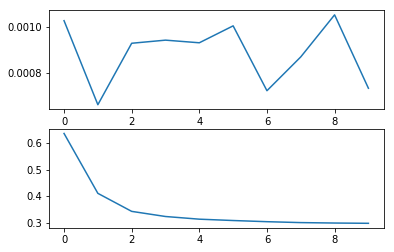

In [102]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

In [ ]:
# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=1., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 0.296385, Train accuracy: 0.000882
Epoch 1, Average loss: 0.295335, Train accuracy: 0.000895
Epoch 2, Average loss: 0.295583, Train accuracy: 0.000688


# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

In [ ]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")